In [3]:
import sys

sys.path.append('/explore/nobackup/people/jacaraba/development/satvision-pix4d')

import os
import torch
import logging
import argparse

from lightning.pytorch import Trainer
from lightning.pytorch.loggers import MLFlowLogger
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor

from satvision_pix4d.configs.config import _C, _update_config_from_file
from satvision_pix4d.utils import get_strategy, get_distributed_train_batches
from satvision_pix4d.pipelines import PIPELINES, get_available_pipelines
from satvision_pix4d.datamodules import DATAMODULES, get_available_datamodules
from satvision_pix4d.models.encoders.mae import build_satmae_model
from satvision_pix4d.datasets.abi_temporal_benchmark_dataset import ABITemporalBenchmarkDataset

model_filename = '/explore/nobackup/projects/pix4dcloud/jacaraba/model_development/satmae/' + \
    'satmae_satvision_pix4d_pretrain-dev/satmae_satvision_pix4d_pretrain-dev/best-epoch=196-val_loss=47.0728.ckpt/checkpoint/mp_rank_00_model_states.pt'

config_filename = '/explore/nobackup/people/jacaraba/development/satvision-pix4d/tests/configs/test_satmae_dev.yaml'

config = _C.clone()
_update_config_from_file(config, config_filename)
print("Loaded configuration file.")

# Add checkpoint (MODEL.PRETRAINED), 
# validation tile dir (DATA.DATA_PATHS),
# and output dir (OUTPUT) to config file
config.defrost()
config.MODEL.PRETRAINED = model_filename
config.DATA.DATA_PATHS = ['/explore/nobackup/people/jacaraba/projects/SatVision-Pix4d/tiles_pix4d/']
config.OUTPUT = '.'
config.freeze()
print("Updated configuration file.")

# Get the proper pipeline
available_pipelines = get_available_pipelines()
print("Available pipelines:", available_pipelines)

pipeline = PIPELINES[config.PIPELINE]
print(f'Using {pipeline}')

ptlPipeline = pipeline(config)

# Resume from checkpoint
print(f'Attempting to resume from checkpoint {config.MODEL.RESUME}')
model = ptlPipeline.load_checkpoint(config.MODEL.PRETRAINED, config)
print(model)
print('Successfully applied checkpoint')

model.cpu()
model.eval()
print('Successfully moved to GPU')



Loaded configuration file.
Updated configuration file.
Available pipelines: {'satvision_pix4d_satmae_pretrain': <class 'satvision_pix4d.pipelines.satvision_pix4d_pretrain.SatVisionPix4DSatMAEPretrain'>}
Using <class 'satvision_pix4d.pipelines.satvision_pix4d_pretrain.SatVisionPix4DSatMAEPretrain'>
Attempting to resume from checkpoint 
SatVisionPix4DSatMAEPretrain(
  (model): MaskedAutoencoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(16, 1024, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): FP32LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): FlashMHAWrapper(
          (attn): MHA(
            (Wqkv): Linear(in_features=1024, out_features=3072, bias=True)
            (inner_attn): SelfAttention(
              (drop): Dropout(p=0.0, inplace=False)
            )
            (inner_cross_attn): CrossAttention(
              (drop): Dropout(p=0.0, inplace=False)
  

In [4]:
from satvision_pix4d.datasets.abi_temporal_dataset import ABITemporalDataset

# Use the new zarr directory
data_dir = '/explore/nobackup/people/jacaraba/projects/SatVision-Pix4d/tiles_pix4d/'

# Get all zarr files for reference
all_zarr_files = [f for f in os.listdir(data_dir) if f.endswith('.zarr')]
print(f"Found {len(all_zarr_files)} zarr files in directory")

# Create dataset using the directory (not individual files)
train_ds = ABITemporalDataset(
    data_paths=[data_dir], 
    img_size=512,
    in_chans=16,
    data_var='Rad'
)

Found 889 zarr files in directory


In [5]:
# not used
from satvision_pix4d.datasets.abi_temporal_dataset import ABITemporalDataset

# Use the directory path, not individual files
data_dir = /home/jacaraba/tiles_pix4d' #'/explore/nobackup/projects/pix4dcloud/jacaraba/tiles_pix4d/3-tiles/convection/20200101'

# Get all zarr files for reference
all_zarr_files = [f for f in os.listdir(data_dir) if f.endswith('.zarr')]
print(f"Found {len(all_zarr_files)} zarr files in directory")

# Create dataset using the directory (not individual files)
train_ds = ABITemporalDataset(
    data_paths=[data_dir], 
    img_size=512,
    in_chans=16,
    data_var='__xarray_dataarray_variable__'
)

SyntaxError: invalid syntax (637743402.py, line 5)

In [6]:

imgs, ts = train_ds[5]  # imgs: (T, C, H, W), ts: (T, 3)

# Normalize this img
print(imgs.shape)

# 3. Move inputs to GPU
imgs = imgs.unsqueeze(0).cpu()  # (B=1, T, C, H, W)
ts = torch.from_numpy(ts).unsqueeze(0).cpu()  # (B=1, T, 3)

# 4. Run inference
with torch.no_grad():
    loss, pred, mask = model(imgs, ts)

# 5. Post-process output
print("🧪 Inference done!")
print(f"Loss: {loss.item():.4f}")
print(f"Pred shape: {pred.shape}  # should be (B, T*P, D)")
print(f"Mask shape: {mask.shape}  # should be (B, T*P)")

# Optional: Convert prediction to images
B, T, C, H, W = imgs.shape
pred_imgs = model.model.unpatchify(pred, T, H, W)
pred_imgs = torch.clamp(pred_imgs, 0, 1)

print(f"Reconstructed images shape: {pred_imgs.shape}  # (B, T, C, H, W)")

torch.Size([6, 16, 512, 512])
🧪 Inference done!
Loss: 0.0638
Pred shape: torch.Size([1, 6144, 4096])  # should be (B, T*P, D)
Mask shape: torch.Size([1, 6144])  # should be (B, T*P)
Reconstructed images shape: torch.Size([1, 6, 16, 512, 512])  # (B, T, C, H, W)


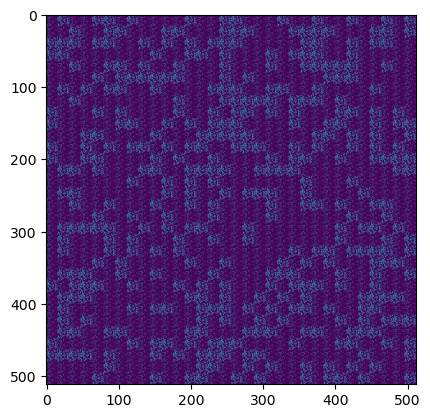

In [7]:
import matplotlib.pyplot as plt
plt.imshow(pred_imgs[0, 0, 10, :, :])

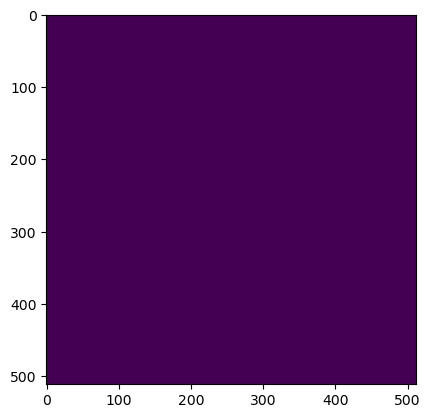

In [8]:
plt.imshow(imgs[0, 0, 10, :, :])

In [13]:
imgs[0, 5, 10, :, :]

IndexError: index 8 is out of bounds for dimension 1 with size 6

In [11]:
pred_imgs[0, 0, 10, :, :]

tensor([[0.0150, 0.0179, 0.0334,  ..., 0.0000, 0.0000, 0.0763],
        [0.0000, 0.0243, 0.0083,  ..., 0.0122, 0.0000, 0.1086],
        [0.0000, 0.0129, 0.0071,  ..., 0.1034, 0.0000, 0.0000],
        ...,
        [0.0007, 0.0017, 0.0000,  ..., 0.0498, 0.0532, 0.0000],
        [0.0034, 0.0398, 0.0263,  ..., 0.0619, 0.0000, 0.0000],
        [0.0209, 0.0069, 0.0194,  ..., 0.0000, 0.0000, 0.0000]])

In [34]:
print(f"imgs shape: {imgs.shape}")
print(f"imgs type: {type(imgs)}")

imgs shape: torch.Size([1, 6, 16, 512, 512])
imgs type: <class 'torch.Tensor'>
